# Plotting Phase Mask and PSF
In this notebook we will load in a optimal phase mask found by the gradient descent algorithm in dLux's tutorials. We will then plot the corresponding PSF as seen by TOLIMAN.

First lets load our relevant modules.

In [1]:
import numpy as np
import dLux as dl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import alphacen

# plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["font.size"] = 18

# for this specific notebook set up
import os
os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


Defining a bunch of parameters.

In [8]:
# Parameters for the bandwidth
bandwidth_min = 545  # minimum wavelength in nm
bandwidth_max = 645  # maximum wavelength in nm
wavels = 1e-9 * np.linspace(bandwidth_min, bandwidth_max, 3)  # wavelengths in m

# Parameters
pa = 90  # position angle in degrees
sep = 10  # binary separation in arcseconds
flux = 6.152e7 / 10 / 2  # AVERAGE flux of the two stars per frame
contrast = 3.372873  # flux contrast from V band magnitudes

# Parameters for dLux
wavefront_npixels = 256  # wavefront layer size
detector_npixels = 2048  # detector size
sampling_rate = 100  # pixels per fringe i.e. 5x Nyquist
detector_pixel_size = dl.utils.get_pixel_scale(sampling_rate, wavels.max(), 0.125)

Loading in the phase mask and converting it to an Optical Path Difference (OPD).

In [9]:
mask_dir = 'data/test_mask.npy'
mask = np.load(mask_dir)
mask_opd = dl.optics.AddOPD(dl.utils.phase_to_opd(mask, wavelength=wavels.mean()))

Creating the TOLIMAN instrument out of the optics and the binary source (Alpha Cen).

In [27]:
# Make optical system
optics = dl.utils.toliman(wavefront_npixels,
                          detector_npixels,
                          detector_pixel_size=dl.utils.radians_to_arcseconds(detector_pixel_size),
                          extra_layers=[mask_opd],
                          angular=True)

# Resetting the pixel scale of output
optics = optics.set(['AngularMFT.pixel_scale_out'], [dl.utils.arcseconds_to_radians(.015)])

# Creating a model Alpha Cen source
source = dl.BinarySource(separation=dl.utils.arcseconds_to_radians(sep),
                         wavelengths=wavels,
                         contrast=contrast,
                         flux=flux,
                         position_angle=np.deg2rad(pa),
                         )

# Creating the instrument by combining optics and source
tol = dl.Instrument(optics=optics, sources=[source])

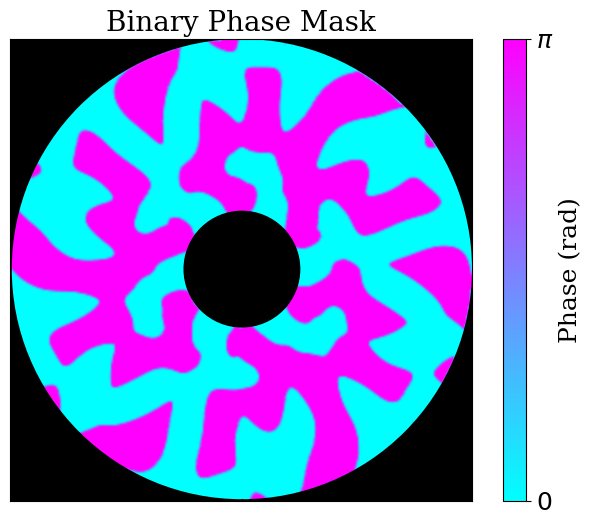

In [58]:
plt.rcParams["font.family"] = "serif"
rmin = 32
rmax = 128
inner = plt.Circle((wavefront_npixels//2, wavefront_npixels//2), rmin, fill=True, color='k')
outer = plt.Circle((wavefront_npixels//2, wavefront_npixels//2), rmax + 38, fill=False, color='k', linewidth=100)

aperture = tol.CircularAperture.aperture

fig, ax = plt.subplots(figsize=(8, 6))
c=ax.imshow(mask*aperture, cmap='cool', interpolation='bicubic')
ax.add_patch(inner)
ax.add_patch(outer)

ax.set(xticks=[], yticks=[],
       title='Binary Phase Mask',
       )
ax.title.set_fontsize(20)
# set the ticks and labels for the colorbar
ticks = np.array([0, np.pi])
labels = [r"${}$".format(int(tick/np.pi)) if tick == 0 else r"$\pi$" for tick in ticks]
cb = fig.colorbar(c,
                 ticks=ticks,
                 format=ticker.FuncFormatter(lambda val, pos: labels[pos]),
                 label='Phase (rad)',
                 )
cb.ax.tick_params(labelsize=18)  # set font size for colorbar tick labels

# plt.savefig('figs/winter-mask.pdf', bbox_inches='tight')
plt.show()

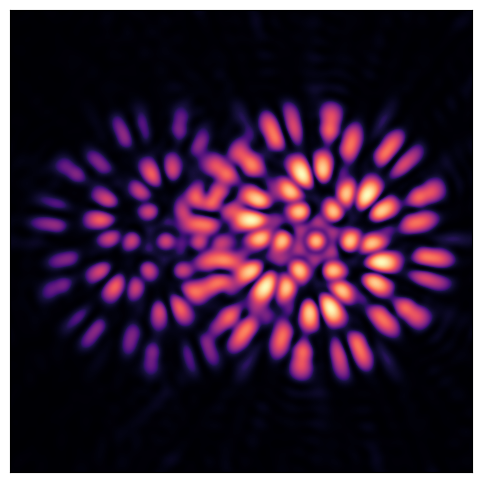

In [93]:
plt.rcParams["font.family"] = "serif"

PSF = tol.model()
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# plotting plot
fig, ax = plt.subplots(figsize=(8, 6))
# set logarithmic color scaling
log_norm = colors.LogNorm(vmin=PSF.min(), vmax=PSF.max())
natlog_norm = colors.SymLogNorm(linthresh=1, linscale=.3, vmin=PSF.min(), vmax=PSF.max(), base=2)

# plot the image with logarithmic scaling
c = ax.imshow(PSF,
              cmap='magma',
              norm=natlog_norm,
              )
# set axis and plot title
ax.set(
       # title=r'$\alpha$ $Cen$ Simulated PSF',
       xticks=[],
       yticks=[])
# # add a colorbar with label and logarithmic scaling
# cb = fig.colorbar(c, ax=ax, label='photons', norm=natlog_norm)
# plt.savefig('figs/PSF-linear.pdf', bbox_inches='tight')
plt.show()


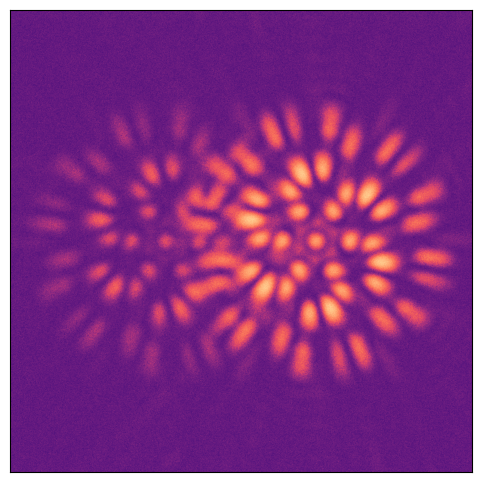

In [90]:
plt.rcParams["font.family"] = "monospace"

# Adding noise
noisy_PSF = np.random.poisson(PSF)
det_noise = np.round(np.random.normal(size=noisy_PSF.shape), decimals=0).astype(int)
noisy_PSF += det_noise

# plotting plot
fig, ax = plt.subplots(figsize=(8, 6))
# set logarithmic color scaling
log_norm = colors.LogNorm(vmin=noisy_PSF.min(), vmax=noisy_PSF.max())
natlog_norm = colors.SymLogNorm(linthresh=4, linscale=1, vmin=noisy_PSF.min(), vmax=noisy_PSF.max(), base=2)
# plot the image with logarithmic scaling
c = ax.imshow(noisy_PSF,
              cmap='magma',
              norm=natlog_norm,
              )
# set axis and plot title
ax.set(
       # title=r'$\alpha$ $Cen$ Simulated PSF',
       xticks=[],
       yticks=[])
# # add a colorbar with label and logarithmic scaling
# cb = fig.colorbar(c, ax=ax, label='photons', norm=natlog_norm)
# plt.savefig('figs/PSF-noisy-weirdstretch.pdf', bbox_inches='tight')
plt.show()